# Geoprocessing

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Geoprocessing" data-toc-modified-id="Geoprocessing-1">Geoprocessing</a></span><ul class="toc-item"><li><span><a href="#Code-from-Notebook-1,-needed-for-in-memory-objects-for-Geoprocessing" data-toc-modified-id="Code-from-Notebook-1,-needed-for-in-memory-objects-for-Geoprocessing-1.1">Code from Notebook 1, needed for in-memory objects for Geoprocessing</a></span></li></ul></li><li><span><a href="#Geoprocessing" data-toc-modified-id="Geoprocessing-2">Geoprocessing</a></span><ul class="toc-item"><li><span><a href="#Point-in-Polygon-Counts-via-Spatial-Join" data-toc-modified-id="Point-in-Polygon-Counts-via-Spatial-Join-2.1">Point-in Polygon Counts via Spatial Join</a></span><ul class="toc-item"><li><span><a href="#Join-Features---Esri-Description" data-toc-modified-id="Join-Features---Esri-Description-2.1.1">Join Features - Esri Description</a></span></li></ul></li></ul></li><li><span><a href="#Exploratory-Data-Analysis---Processed-Data" data-toc-modified-id="Exploratory-Data-Analysis---Processed-Data-3">Exploratory Data Analysis - Processed Data</a></span><ul class="toc-item"><li><span><a href="#Explore-Missing-Data-in-Post-Geoprocessed-Nightfire-spatially-joined-with-Basin-data." data-toc-modified-id="Explore-Missing-Data-in-Post-Geoprocessed-Nightfire-spatially-joined-with-Basin-data.-3.1">Explore Missing Data in Post-Geoprocessed Nightfire spatially joined with Basin data.</a></span></li><li><span><a href="#Keep-obs_day_cnt,-looks-reliable." data-toc-modified-id="Keep-obs_day_cnt,-looks-reliable.-3.2">Keep <code>obs_day_cnt</code>, looks reliable.</a></span><ul class="toc-item"><li><span><a href="#Drop-qf_detect" data-toc-modified-id="Drop-qf_detect-3.2.1">Drop <code>qf_detect</code></a></span></li></ul></li></ul></li><li><span><a href="#Keep-qf_fit" data-toc-modified-id="Keep-qf_fit-4">Keep <code>qf_fit</code></a></span></li></ul></div>

In [48]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [84]:
import glob
import geopandas as gpd
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

In [50]:
from tools.tools import read_json, get_current_time
from capstone.etl.viirs_join_basins import viirs_join_basins, compile_basin_data
from capstone.etl.census_parse import parse_census
from capstone.etl.census_retrieval import census_retrieval
from capstone.etl.generate_basins import generate_us_basins
from capstone.etl.eia_retrieval import eia_retrieval
from capstone.etl.eia_parse import eia_parse_county, eia_parse_data

In [82]:
config = read_json('../config.json')

current_date = get_current_time('yyyymmdd')

wd = f"{config['workspace_directory']}/data"

In [218]:
plt.style.use('ggplot')

In [219]:
basin_colors_hex = {  # manually defined dictionary of EIA basin-level standardized colors 
    "Anadarko Region":    "#2BA2CF", 
    "Appalachia Region":  "#769F5D",
    "Bakken Region":      "#F6C432", 
    "Eagle Ford Region":  "#48366B", 
    "Haynesville Region": "#807B8F",
    "Niobrara Region":    "#9D3341",
    "Permian Region":     "#6F4B27",
}

## Code from Notebook 1, needed for in-memory objects for Geoprocessing

In [149]:
census_shp = census_retrieval(f"{wd}/input/census")
census = gpd.read_file(census_shp)
census.columns = [c.lower() for c in census.columns]

eia_xls = eia_retrieval(f"{wd}/input/eia")
eia_cnty = eia_parse_county(eia_xls)
eia_data = eia_parse_data(eia_xls)  # parse the target variable(s) data

census_gdf = parse_census(census_shp)
basins_list, all_basins = generate_us_basins(
    census_gdf,
    eia_cnty,
    f"{wd}/input/basins",
)  # this code creates individual files for basin geographies as well as an all_basins geography file/object.

 parse eia data
    for Anadarko Region
    for Appalachia Region
    for Bakken Region
    for Eagle Ford Region
    for Haynesville Region
    for Niobrara Region
    for Permian Region
generating us basins
    permian region
    appalachia region
    haynesville region
    eagle ford region
    anadarko region
    niobrara region
    bakken region


# Geoprocessing

In [41]:
# get lists of all the retrieved viirs data for both 2.1c and 3.0 viirs

viirs_2_1c_files = glob.glob(f"{wd}/input/viirs21c/*.csv")  # get viirs
viirs_2_1c_files.sort()  # sort so dates are consecutive for tracking

print(f'Total 2.1c files: {len(viirs_2_1c_files)}')

viirs_3_0_files = glob.glob(f"{wd}/input/viirs30/*.csv")  # get viirs files
viirs_3_0_files.sort()  # sort so dates are consecutive for tracking

print(f'Total 3.0 files: {len(viirs_3_0_files)}')

Total 2.1c files: 2095
Total 3.0 files: 824


## Point-in Polygon Counts via Spatial Join

While Join Features tool was not used (rather GeoPandas S-Join for Spatial Join), this illustration better shows how a given geography 2d or 3d polygon, is intersected with points, we can count those features inside. 

### Join Features - Esri Description 

> Joins attributes from one layer to another based on spatial, temporal, or attribute relationships, or a combination of those relationships. [https://pro.arcgis.com/en/pro-app/tool-reference/geoanalytics-desktop/join-features.htm](https://pro.arcgis.com/en/pro-app/tool-reference/geoanalytics-desktop/join-features.htm)

[![join](https://pro.arcgis.com/en/pro-app/tool-reference/geoanalytics-desktop/GUID-EB8FA998-105A-4D93-93E3-5FAA1057137D-web.png)](https://pro.arcgis.com/en/pro-app/tool-reference/geoanalytics-desktop/GUID-EB8FA998-105A-4D93-93E3-5FAA1057137D-web.png)


Geopandas code inside `tools.geoprocessing.py` which is used inside `viirs_join_basins(...)`  in this project repository:
```python
import geopandas as gpd


def point_in_polygon(point_gdf, poly_gdf):
    return gpd.sjoin(
        point_gdf,
        poly_gdf,
        how="inner",
        op='intersects',  # warning CRS of frames do not match
    )
```

In [42]:
viirs_join_basins( 
    wd,
    all_basins,
    viirs_2_1c_files,
    '21c',
)   # spatially join viirs 2.1c to basins geometries

viirs_join_basins(
    wd,
    all_basins,
    viirs_3_0_files,
    '30',
)  # spatially join viirs 3.0 to basins geometries

selecting viirs for basins 21c
    20120301
    20120302
    20120303
    20120304
    20120305
    20120306
    20120307
    20120308
    20120309
    20120310
    20120311
    20120312
    20120313
    20120314
    20120315
    20120316
    20120317
    20120318
    20120319
    20120320
    20120321
    20120322
    20120323
    20120324
    20120326
    20120327
    20120328
    20120329
    20120330
    20120331
    20120401
    20120402
    20120403
    20120404
    20120405
    20120406
    20120407
    20120408
    20120409
    20120410
    20120411
    20120412
    20120413
    20120414
    20120415
    20120416
    20120417
    20120418
    20120419
    20120420
    20120421
    20120422
    20120423
    20120424
    20120425
    20120426
    20120427
    20120428
    20120429
    20120430
    20120501
    20120502
    20120503
    20120504
    20120505
    20120506
    20120507
    20120508
    20120509
    20120510
    20120511
    20120512
    20120513
    20120514
    201

    20160314
    20160315
    20160316
    20160317
    20160318
    20160319
    20160320
    20160321
    20160322
    20160323
    20160324
    20160325
    20160326
    20160327
    20160328
    20160329
    20160330
    20160331
    20160401
    20160402
    20160403
    20160404
    20160405
    20160406
    20160407
    20160408
    20160409
    20160410
    20160411
    20160412
    20160413
    20160414
    20160415
    20160416
    20160417
    20160418
    20160419
    20160420
    20160421
    20160422
    20160423
    20160424
    20160425
    20160426
    20160427
    20160428
    20160429
    20160430
    20160501
    20160502
    20160503
    20160504
    20160505
    20160506
    20160507
    20160508
    20160509
    20160510
    20160511
    20160512
    20160513
    20160514
    20160515
    20160516
    20160517
    20160518
    20160519
    20160520
    20160521
    20160522
    20160523
    20160524
    20160525
    20160526
    20160527
    20160528
    20160529

    20181205
    20181206
    20181207
    20181208
    20181209
    20181210
    20181211
    20181212
    20181213
    20181214
    20181215
    20181216
    20181217
    20181218
    20181219
    20181220
    20181221
    20181222
    20181223
    20181224
    20181225
    20181226
    20181227
    20181228
    20181229
    20181230
    20181231
    20190101
    20190102
    20190103
    20190104
    20190105
    20190106
    20190107
    20190108
    20190109
    20190110
    20190111
    20190112
    20190113
    20190114
    20190115
    20190116
    20190117
    20190118
    20190119
    20190120
    20190121
    20190122
    20190123
    20190124
    20190125
    20190126
    20190127
    20190128
    20190129
    20190130
    20190131
    20190201
    20190202
    20190203
    20190204
    20190205
    20190206
    20190207
    20190208
    20190209
    20190210
    20190211
    20190212
    20190213
    20190214
    20190215
    20190216
    20190217
    20190218
    20190219

In [45]:
basins_int_viirs_21c = compile_basin_data(wd, '21c')
basins_int_viirs_30  = compile_basin_data(wd, '30')

    20120301
    20120302
    20120303
    20120304
    20120305
    20120306
    20120307
    20120308
    20120309
    20120310
    20120311
    20120312
    20120313
    20120314
    20120315
    20120316
    20120317
    20120318
    20120319
    20120320
    20120321
    20120322
    20120323
    20120324
    20120326
    20120327
    20120328
    20120329
    20120330
    20120331
    20120401
    20120402
    20120403
    20120404
    20120405
    20120406
    20120407
    20120408
    20120409
    20120410
    20120411
    20120412
    20120413
    20120414
    20120415
    20120416
    20120417
    20120418
    20120419
    20120420
    20120421
    20120422
    20120423
    20120424
    20120425
    20120426
    20120427
    20120428
    20120429
    20120430
    20120501
    20120502
    20120503
    20120504
    20120505
    20120506
    20120507
    20120508
    20120509
    20120510
    20120511
    20120512
    20120513
    20120514
    20120515
    20120516
    20120517

    20131125
    20131126
    20131127
    20131128
    20131129
    20131130
    20131201
    20131202
    20131203
    20131204
    20131205
    20131206
    20131207
    20131208
    20131209
    20131210
    20131211
    20131212
    20131213
    20131214
    20131215
    20131216
    20131217
    20131218
    20131219
    20131220
    20131221
    20131222
    20131223
    20131224
    20131225
    20131226
    20131227
    20131228
    20131229
    20131230
    20131231
    20140101
    20140102
    20140103
    20140104
    20140105
    20140106
    20140107
    20140108
    20140109
    20140110
    20140111
    20140112
    20140113
    20140114
    20140115
    20140116
    20140117
    20140118
    20140119
    20140120
    20140121
    20140122
    20140123
    20140124
    20140125
    20140126
    20140127
    20140128
    20140129
    20140130
    20140131
    20140201
    20140202
    20140203
    20140204
    20140205
    20140206
    20140207
    20140208
    20140209

    20150818
    20150819
    20150820
    20150821
    20150822
    20150823
    20150824
    20150825
    20150826
    20150827
    20150828
    20150829
    20150830
    20150831
    20150901
    20150902
    20150903
    20150904
    20150905
    20150906
    20150907
    20150908
    20150909
    20150910
    20150911
    20150912
    20150913
    20150914
    20150915
    20150916
    20150917
    20150918
    20150919
    20150920
    20150921
    20150922
    20150923
    20150924
    20150925
    20150926
    20150927
    20150928
    20150929
    20150930
    20151001
    20151002
    20151003
    20151004
    20151005
    20151006
    20151007
    20151008
    20151009
    20151010
    20151011
    20151012
    20151013
    20151014
    20151015
    20151016
    20151017
    20151018
    20151019
    20151020
    20151021
    20151022
    20151023
    20151024
    20151025
    20151026
    20151027
    20151028
    20151029
    20151030
    20151031
    20151101
    20151102

    20170510
    20170511
    20170512
    20170518
    20170519
    20170520
    20170521
    20170522
    20170523
    20170524
    20170525
    20170526
    20170527
    20170528
    20170529
    20170530
    20170531
    20170601
    20170602
    20170603
    20170604
    20170605
    20170606
    20170607
    20170608
    20170609
    20170610
    20170611
    20170612
    20170613
    20170614
    20170615
    20170616
    20170617
    20170618
    20170619
    20170620
    20170621
    20170622
    20170623
    20170624
    20170625
    20170626
    20170627
    20170628
    20170629
    20170630
    20170701
    20170702
    20170703
    20170704
    20170705
    20170706
    20170707
    20170708
    20170709
    20170710
    20170711
    20170712
    20170713
    20170714
    20170715
    20170716
    20170717
    20170718
    20170719
    20170720
    20170721
    20170722
    20170723
    20170724
    20170725
    20170726
    20170727
    20170728
    20170729
    20170730

    20190206
    20190207
    20190208
    20190209
    20190210
    20190211
    20190212
    20190213
    20190214
    20190215
    20190216
    20190217
    20190218
    20190219
    20190220
    20190221
    20190222
    20190223
    20190224
    20190225
    20190226
    20190227
    20190228
    20190301
    20190302
    20190303
    20190304
    20190305
    20190306
    20190307
    20190308
    20190309
    20190310
    20190311
    20190312
    20190313
    20190314
    20190315
    20190316
    20190317
    20190318
    20190319
    20190320
    20190321
    20190322
    20190323
    20190324
    20190325
    20190326
    20190327
    20190328
    20190329
    20190330
    20190331
    20190401
    20190402
    20190403
    20190404
    20190405
    20190406
    20190407
    20190408
    20190409
    20190410
    20190411
    20190412
    20190413
    20190414
    20190415
    20190416
    20190417
    20190418
    20190419
    20190420
    20190421
    20190422
    20190423

In [89]:
print(basins_int_viirs_21c.shape)
print(basins_int_viirs_30.shape)

(1009001, 44)
(523075, 44)


# Exploratory Data Analysis - Processed Data
Port this code to Notebook 4

In [127]:
basins_int_viirs_21c = pd.read_csv(  # temporary intermediate file read for working on MacBook rather than iMac
    f"{wd}/processing/basins_int_viirs_21c.csv",
    dtype={'geoid': object},
)
basins_int_viirs_30  = pd.read_csv(
    f"{wd}/processing/basins_int_viirs_30.csv",
    dtype={'geoid': object},
)

In [128]:
basins_int_viirs_21c.head(3)

,aland,area_bb,area_pixel,awater,cbsafp,ch_m12,ch_m13,classfp,cloud_mask,co2_eq,...,thr_m16,tran_dnb,tran_m07,tran_m08,tran_m10,tran_m12,tran_m13,tran_m14,tran_m15,tran_m16
0,4727469721,NaN,NaN,301107657,NaN,0.000000;0.062081;0.086345;0.112419;0.157635;0...,0.000000;0.074897;0.106120;0.150975;0.234767;0...,H1,0.0,NaN,...,6.84127,1,1,1,1,1,1,1,1,1
1,4727469721,NaN,NaN,301107657,NaN,0.000000;0.062081;0.086345;0.112419;0.157635;0...,0.000000;0.074897;0.106120;0.150975;0.234767;0...,H1,0.0,NaN,...,6.84127,1,1,1,1,1,1,1,1,1
2,4727469721,NaN,NaN,301107657,NaN,0.000000;0.062081;0.086345;0.112419;0.157635;0...,0.000000;0.074897;0.106120;0.150975;0.234767;0...,H1,0.0,NaN,...,6.84127,1,1,1,1,1,1,1,1,1


In [129]:
basins_int_viirs_30.head(3)

,aland,area_bb,area_pixel,awater,cbsafp,classfp,cloud_mask,co2_eq,countyfp,countyns,...,qf_fit,region,rh,rhi,sample_dnb,sample_m10,source_id,statefp,temp_bb,temp_bkg
0,5381129960,NaN,NaN,182522236,48780.0,H1,3.0,NaN,105,1035306,...,0.0,Bakken Region,NaN,NaN,1523.0,1142.0,NaN,38,NaN,NaN
1,5381129960,1.1615,0.811394,182522236,48780.0,H1,3.0,NaN,105,1035306,...,1.0,Bakken Region,0.792865,0.977164,1522.0,1142.0,NaN,38,1863.0,NaN
2,5381129960,NaN,NaN,182522236,48780.0,H1,3.0,NaN,105,1035306,...,0.0,Bakken Region,NaN,NaN,1553.0,1166.0,NaN,38,NaN,NaN


In [130]:
common_cols = list(basins_int_viirs_21c.columns & basins_int_viirs_30.columns)  
# generate list of common columns for intersected viirs version 2.1c and 3.0 

In [131]:
basins_int_viirs_21c = basins_int_viirs_21c[common_cols]
basins_int_viirs_30 = basins_int_viirs_30[common_cols]
# unify the dataframes for 2.1c and 3.0 intersected viirs

In [270]:
df = pd.concat([basins_int_viirs_21c, basins_int_viirs_30], sort=True)  
# combine 2.1c and 3.0 int viirs

In [271]:
df.shape

(1532076, 44)

In [272]:
df['date_mscan'].head(3)  # sanity check to see first dates from 2.1c are up in hereee.

0    2012/03/01 10:10:41.916
1    2012/03/01 10:10:41.916
2    2012/03/01 10:10:43.695
Name: date_mscan, dtype: object

In [273]:
df['date_mscan'].tail(3)  # sanity check to see latest dates from 3.0 are up in hereee.

523072    2020/03/03 09:47:09.406
523073    2020/03/03 08:07:20.386
523074    2020/03/03 09:47:37.874
Name: date_mscan, dtype: object

In [274]:
df['region'].unique()  # sanity check, regions, sup. 

array(['Bakken Region', 'Niobrara Region', 'Anadarko Region',
       'Haynesville Region', 'Permian Region', 'Eagle Ford Region',
       'Appalachia Region'], dtype=object)

In [275]:
df.shape  # shape of v3.0 and v2.1c combined

(1532076, 44)

## Explore Missing Data in Post-Geoprocessed Nightfire spatially joined with Basin data. 

The Nightfire datasets have known missing values in some of the metrics and some columns that are completely incomplete, for example those that refer to CO2 and Methane detection via the multispectral bands. This is expeceted. These and other missing data will be dropped. Mostly the aim will be to leverage and generate descriptive statistics about the counts per units of time as well as the temperature related variables. 

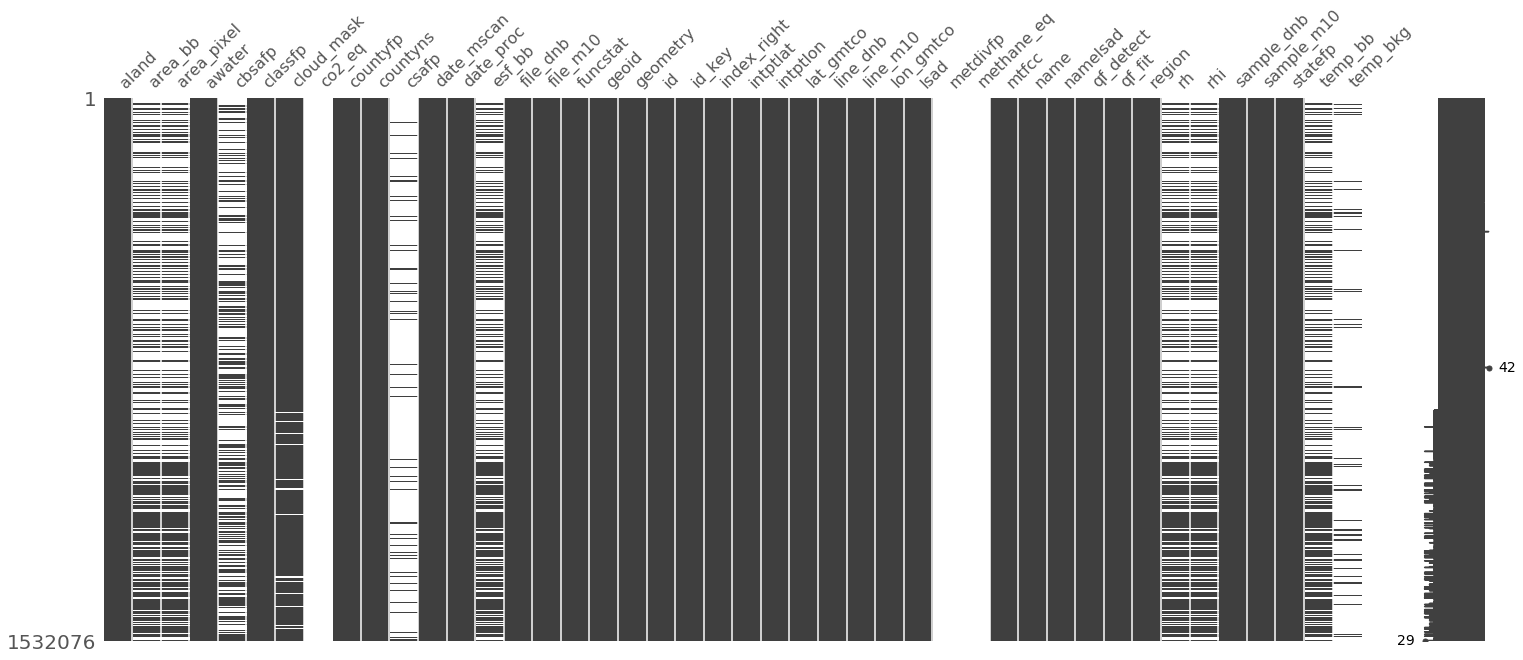

In [276]:
msno.matrix(df);  # showing NaN data.

In [277]:
df.isnull().sum()  # which columns have nulls

aland                0
area_bb         804917
area_pixel      804917
awater               0
cbsafp          970472
classfp              0
cloud_mask       36380
co2_eq         1532076
countyfp             0
countyns             0
csafp          1420681
date_mscan           0
date_proc            0
esf_bb          804917
file_dnb             0
file_m10             0
funcstat             0
geoid                0
geometry             0
id                   0
id_key               0
index_right          0
intptlat             0
intptlon             0
lat_gmtco            0
line_dnb          1116
line_m10             0
lon_gmtco            0
lsad                 0
metdivfp       1532032
methane_eq     1532076
mtfcc                0
name                 0
namelsad             0
qf_detect            0
qf_fit               0
region               0
rh              804917
rhi             804917
sample_dnb        1116
sample_m10           0
statefp              0
temp_bb         804917
temp_bkg   

In [278]:
# drop very incomplete columns and unnecessary census county columns. 
df = df.drop(
    columns=[
        'metdivfp',  # drop these b/c majority missing, not useful
        'methane_eq',
        'temp_bkg',
        'csafp',
        'co2_eq',  # drop these b/c majority missing, not useful
        'file_dnb',  # more viirs to drop
        'file_m10',
        'id', 
        'id_key',
        'line_dnb',
        'line_m10',
        'sample_dnb',
        'sample_m10',
        'cloud_mask',
        'date_proc',  # don't need processed date, use date_mscan
        'lat_gmtco',  # viirs lat
        'lon_gmtco',  # viirs lon
        'statefp',  # census variables not useful
        'countyfp',
        'countyns',
        'name',
        'namelsad',
        'lsad',
        'classfp',
        'mtfcc',
        'cbsafp',
        'intptlat',
        'intptlon',
        'awater',
        'funcstat',  # census variables not useful
        'index_right',  # not useful but maybe check where this came from 
    ],
)
df.isnull().sum()  # nulls after dropping columns, this is expected

aland              0
area_bb       804917
area_pixel    804917
date_mscan         0
esf_bb        804917
geoid              0
geometry           0
qf_detect          0
qf_fit             0
region             0
rh            804917
rhi           804917
temp_bb       804917
dtype: int64

In [279]:
# reorder the variables manually 
df = df[[
    'date_mscan',
    'geometry',
    'region',
    'geoid',
    'aland',
    'qf_detect',
    'qf_fit',
    'area_bb',
    'area_pixel',
    'esf_bb',
    'rh',
    'rhi',
    'temp_bb',
]]

In [280]:
df_complete_rows = df.dropna()

In [281]:
df_complete_rows.shape  
# this is data that will be set aside and used if temperature and other data is leveraged

(727159, 13)

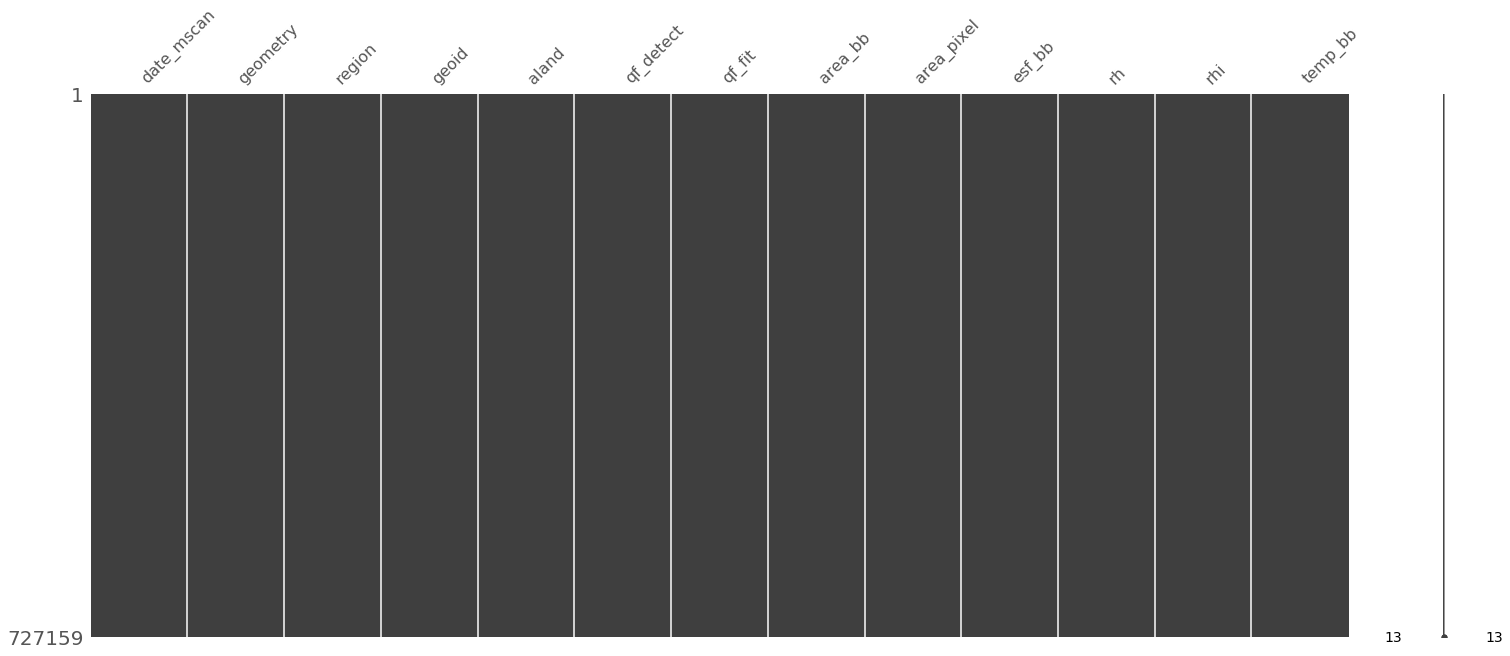

In [282]:
msno.matrix(df_complete_rows);  # showing completely filled data observations

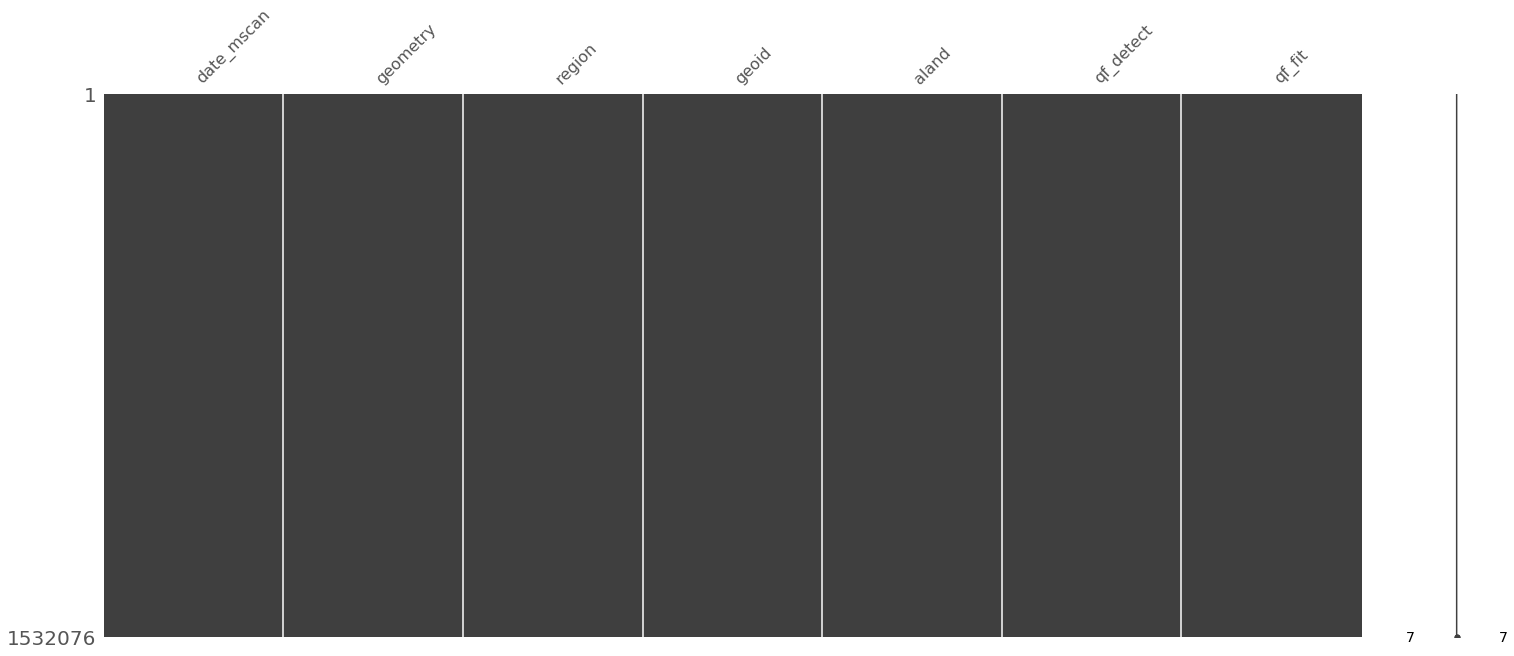

In [283]:
df = df.dropna(axis=1, how='any')
msno.matrix(df);  # df, now only has columns that are complete. 

In [284]:
df['date'] = pd.to_datetime(df['date_mscan']).dt.date

df_for_agg = df[['date', 'region', 'geoid', 'qf_detect', 'qf_fit']]
df_for_agg['geoid'].dtypes

dtype('O')

In [288]:
census_gdf['geoid'].dtypes  # check data type for geoid, make sure object

dtype('O')

In [289]:
df_for_agg

,date,region,geoid,qf_detect,qf_fit
0,2012-03-01,Bakken Region,38061,2049.0,0.0
1,2012-03-01,Bakken Region,38061,2371.0,0.0
2,2012-03-01,Bakken Region,38061,2177.0,0.0
3,2012-03-01,Bakken Region,38061,2499.0,0.0
4,2012-03-01,Bakken Region,38061,2433.0,0.0
...,...,...,...,...,...
523070,2020-03-03,Niobrara Region,56009,442177.0,1.0
523071,2020-03-03,Niobrara Region,56009,3905.0,0.0
523072,2020-03-03,Niobrara Region,56009,2881.0,0.0
523073,2020-03-03,Niobrara Region,8123,376643.0,1.0


In [320]:
df_for_agg['count'] = 1

df_day_agg = df_for_agg.groupby(
    ["date", "region"],
).agg(
    obs_day_cnt=pd.NamedAgg(column='count', aggfunc='sum'),
    qf_detect_day_avg=pd.NamedAgg(column='qf_detect', aggfunc='mean'),
    qf_detect_day_med=pd.NamedAgg(column='qf_detect', aggfunc='median'),
    qf_detect_day_sum=pd.NamedAgg(column='qf_detect', aggfunc='sum'),
    qf_detect_day_min=pd.NamedAgg(column='qf_detect', aggfunc='min'),
    qf_detect_day_max=pd.NamedAgg(column='qf_detect', aggfunc='max'),
    qf_fit_day_avg=pd.NamedAgg(column='qf_fit', aggfunc='mean'),
    qf_fit_day_med=pd.NamedAgg(column='qf_fit', aggfunc='median'),
    qf_fit_day_sum=pd.NamedAgg(column='qf_fit', aggfunc='sum'),
    qf_fit_day_min=pd.NamedAgg(column='qf_fit', aggfunc='min'),
    qf_fit_day_max=pd.NamedAgg(column='qf_fit', aggfunc='max'),
).reset_index()

/Users/danielmsheehan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


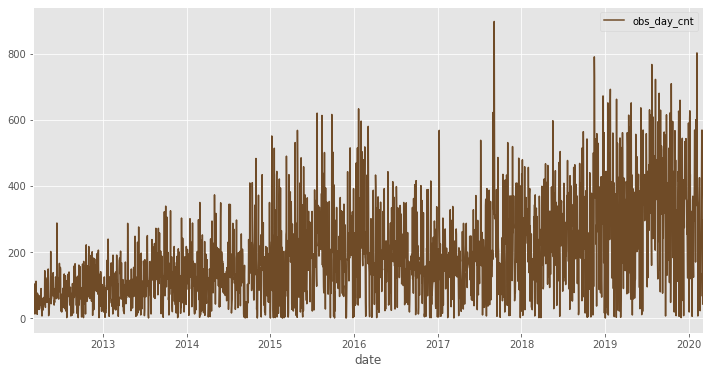

In [321]:
region = 'Permian Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['obs_day_cnt']].plot(
    figsize=(12, 6), 
    c=basin_colors_hex[region],
);

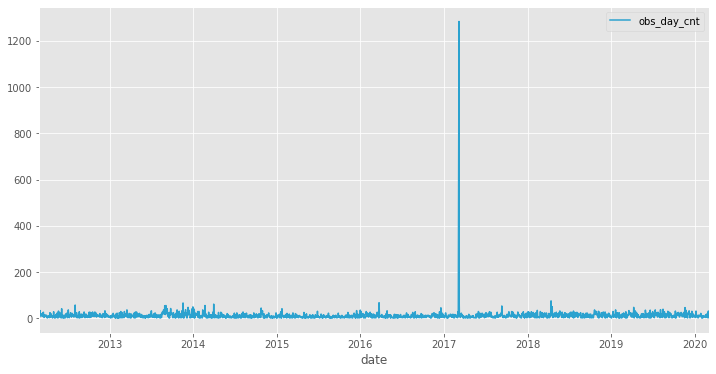

In [322]:
region = 'Anadarko Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['obs_day_cnt']].plot(
    figsize=(12, 6), 
    c=basin_colors_hex[region],
);  # seems to be some weird event in Anadarko Region 

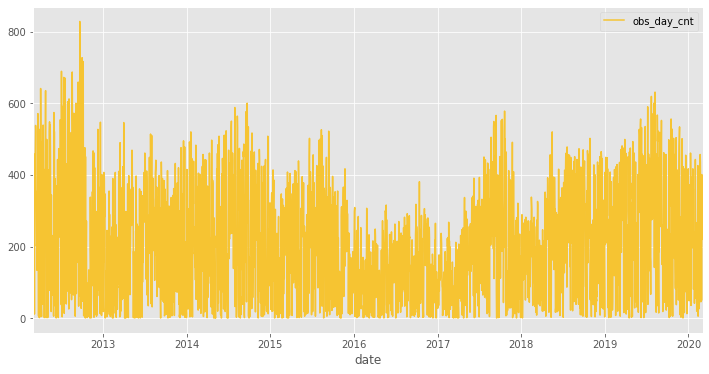

In [323]:
region = 'Bakken Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['obs_day_cnt']].plot(
    figsize=(12, 6), 
    c=basin_colors_hex[region],
);

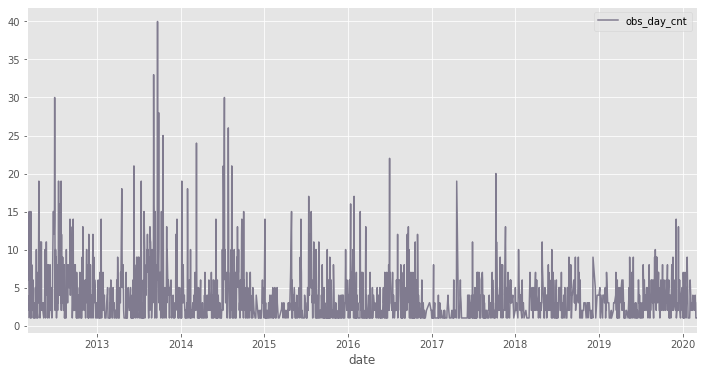

In [324]:
region = 'Haynesville Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['obs_day_cnt']].plot(
    figsize=(12, 6), 
    c=basin_colors_hex[region],
);

## Keep `obs_day_cnt`, looks reliable.  

Anadarko region has something strange, but there is a large fire in 2017. Unclear at this point whether to drop. 

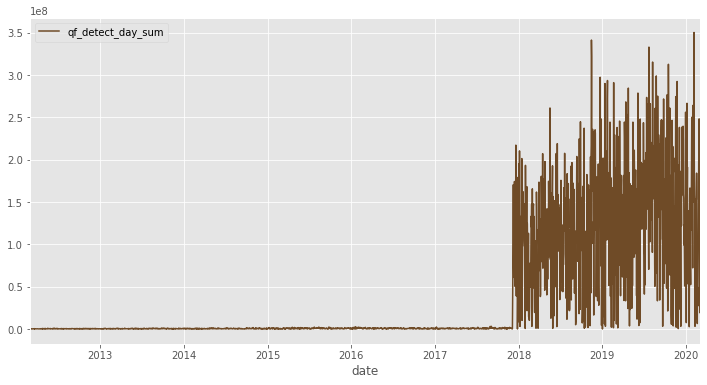

In [329]:
region = 'Permian Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_detect_day_sum']].plot(
    figsize=(12, 6),
    c=basin_colors_hex[region],
);

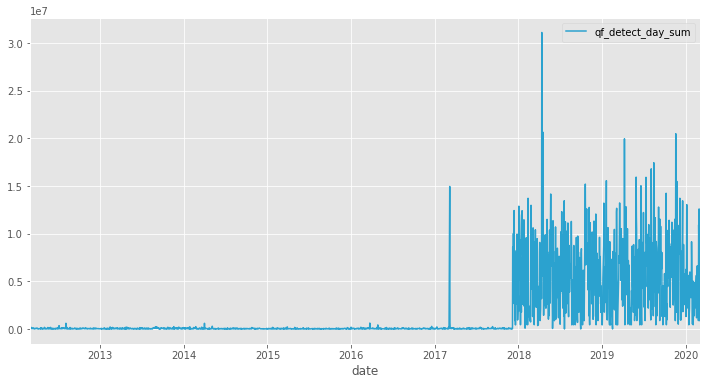

In [328]:
region = 'Anadarko Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_detect_day_sum']].plot(
    figsize=(12, 6),
    c=basin_colors_hex[region],
);

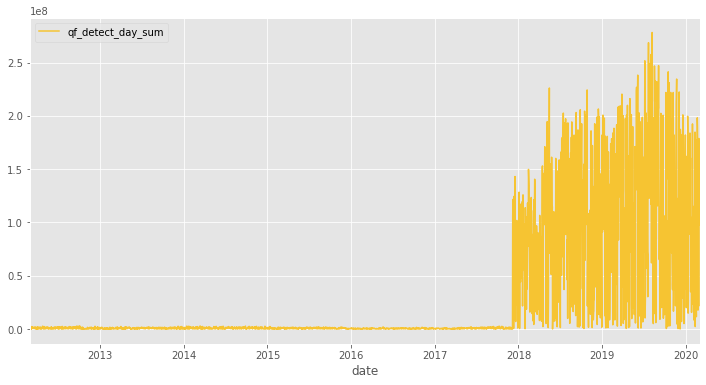

In [327]:
region = 'Bakken Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_detect_day_sum']].plot(
    figsize=(12, 6),
    c=basin_colors_hex[region],
);

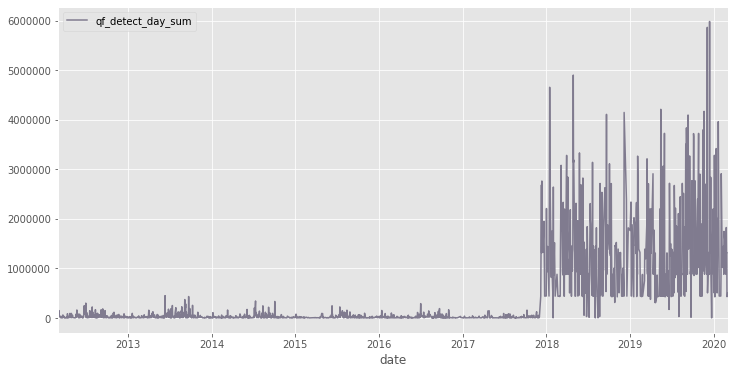

In [326]:
region = 'Haynesville Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_detect_day_sum']].plot(
    figsize=(12, 6),
    c=basin_colors_hex[region],
);

In [302]:
df_day_agg.drop(
    columns=[
        'qf_detect_day_avg',
        'qf_detect_day_med',
        'qf_detect_day_sum',
        'qf_detect_day_min',
        'qf_detect_day_max',
    ],
    inplace=True
)

### Drop `qf_detect` 
From the plots above, I can summize that `qf_detect` variables are systematically different from v2.1c to 3.0.

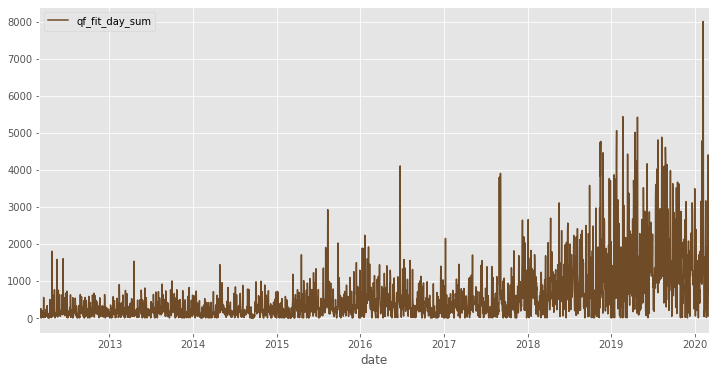

In [303]:
region = 'Permian Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_fit_day_sum']].plot(
    figsize=(12, 6), 
    c=basin_colors_hex[region],
);

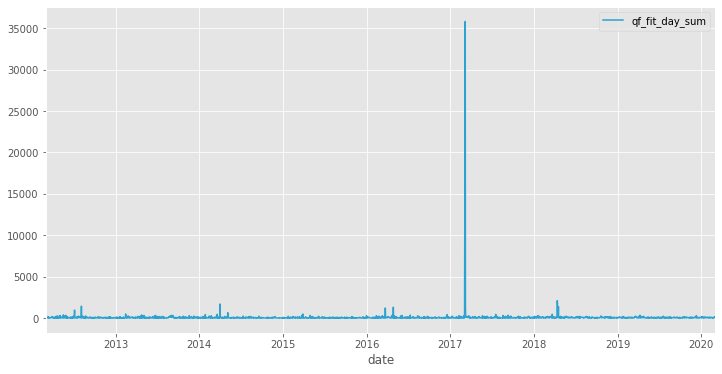

In [304]:
region = 'Anadarko Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_fit_day_sum']].plot(
    figsize=(12, 6), 
    c=basin_colors_hex[region],
);  # weird noise, but perhaps acceptable

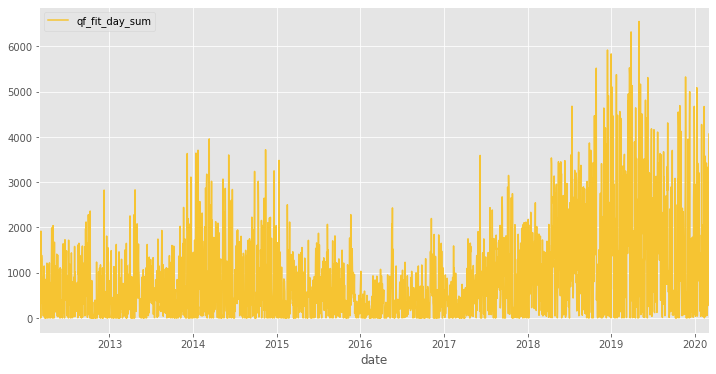

In [305]:
region = 'Bakken Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_fit_day_sum']].plot(
    figsize=(12, 6), 
    c=basin_colors_hex[region],
);

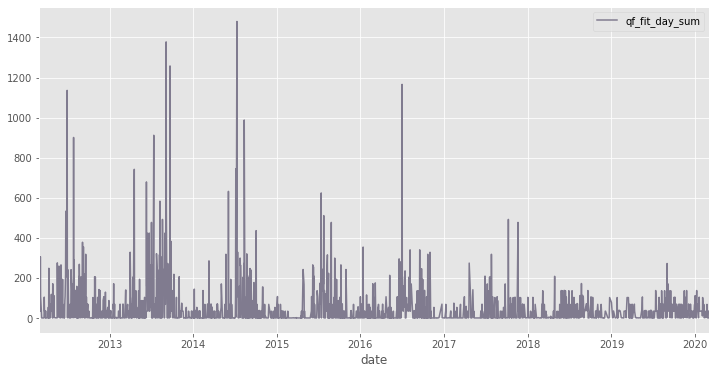

In [306]:
region = 'Haynesville Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_fit_day_sum']].plot(
    figsize=(12, 6), 
    c=basin_colors_hex[region],
);

# Keep `qf_fit`
The `qf_fit` variable doesn't seem to have the systematic error as `qf_detect`. 


In [331]:
df_day_agg['year_month'] = pd.to_datetime(
    df_day_agg['date'].apply(lambda x: x.strftime('%Y-%m'))
)  # create year_month column

df_day_agg

,date,region,obs_day_cnt,qf_detect_day_avg,qf_detect_day_med,qf_detect_day_sum,qf_detect_day_min,qf_detect_day_max,qf_fit_day_avg,qf_fit_day_med,qf_fit_day_sum,qf_fit_day_min,qf_fit_day_max,year_month
0,2012-03-01,Anadarko Region,10,4309.400000,3397.0,43094.0,2049.0,16241.0,3.700000,0.0,37.0,0.0,34.0,2012-03-01
1,2012-03-01,Appalachia Region,7,8214.142857,3841.0,57499.0,2309.0,16177.0,14.714286,1.0,103.0,0.0,34.0,2012-03-01
2,2012-03-01,Bakken Region,205,4014.482927,3841.0,822969.0,2049.0,16381.0,2.365854,0.0,485.0,0.0,34.0,2012-03-01
3,2012-03-01,Eagle Ford Region,31,3179.451613,2889.0,98563.0,2177.0,4045.0,0.322581,0.0,10.0,0.0,1.0,2012-03-01
4,2012-03-01,Haynesville Region,1,14641.000000,14641.0,14641.0,14641.0,14641.0,34.000000,34.0,34.0,34.0,34.0,2012-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18407,2020-03-02,Permian Region,43,452261.581395,442365.0,19447248.0,2881.0,507725.0,1.209302,0.0,52.0,0.0,34.0,2020-03-01
18408,2020-03-03,Anadarko Region,2,441657.000000,441657.0,883314.0,441153.0,442161.0,17.500000,17.5,35.0,1.0,34.0,2020-03-01
18409,2020-03-03,Bakken Region,371,428634.412399,442177.0,159023367.0,2369.0,507775.0,10.956873,1.0,4065.0,0.0,34.0,2020-03-01
18410,2020-03-03,Eagle Ford Region,3,481003.333333,506177.0,1443010.0,430144.0,506689.0,0.666667,1.0,2.0,0.0,1.0,2020-03-01


In [401]:
df_month_agg = df_day_agg.groupby(
    ["year_month", "region"],
).agg(
    obs_day_cnt_avg=pd.NamedAgg(column='obs_day_cnt', aggfunc='mean'),
    obs_day_cnt_med=pd.NamedAgg(column='obs_day_cnt', aggfunc='median'),
    obs_day_cnt_sum=pd.NamedAgg(column='obs_day_cnt', aggfunc='sum'),
    obs_day_cnt_min=pd.NamedAgg(column='obs_day_cnt', aggfunc='min'),
    obs_day_cnt_max=pd.NamedAgg(column='obs_day_cnt', aggfunc='max'),
    
    qf_fit_day_avg_avg=pd.NamedAgg(column='qf_fit_day_avg', aggfunc='mean'),
    qf_fit_day_avg_med=pd.NamedAgg(column='qf_fit_day_avg', aggfunc='median'),
    qf_fit_day_avg_sum=pd.NamedAgg(column='qf_fit_day_avg', aggfunc='sum'),
    qf_fit_day_avg_min=pd.NamedAgg(column='qf_fit_day_avg', aggfunc='min'),
    qf_fit_day_avg_max=pd.NamedAgg(column='qf_fit_day_avg', aggfunc='max'),

    qf_fit_day_med_avg=pd.NamedAgg(column='qf_fit_day_med', aggfunc='mean'),
    qf_fit_day_med_med=pd.NamedAgg(column='qf_fit_day_med', aggfunc='median'),
    qf_fit_day_med_sum=pd.NamedAgg(column='qf_fit_day_med', aggfunc='sum'),
    qf_fit_day_med_min=pd.NamedAgg(column='qf_fit_day_med', aggfunc='min'),
    qf_fit_day_med_max=pd.NamedAgg(column='qf_fit_day_med', aggfunc='max'),
    
    qf_fit_day_sum_avg=pd.NamedAgg(column='qf_fit_day_sum', aggfunc='mean'),
    qf_fit_day_sum_med=pd.NamedAgg(column='qf_fit_day_sum', aggfunc='median'),
    qf_fit_day_sum_sum=pd.NamedAgg(column='qf_fit_day_sum', aggfunc='sum'),
    qf_fit_day_sum_min=pd.NamedAgg(column='qf_fit_day_sum', aggfunc='min'),
    qf_fit_day_sum_max=pd.NamedAgg(column='qf_fit_day_sum', aggfunc='max'),
  
    qf_fit_day_min_avg=pd.NamedAgg(column='qf_fit_day_min', aggfunc='mean'),
    qf_fit_day_min_med=pd.NamedAgg(column='qf_fit_day_min', aggfunc='median'),
    qf_fit_day_min_sum=pd.NamedAgg(column='qf_fit_day_min', aggfunc='sum'),
    qf_fit_day_min_min=pd.NamedAgg(column='qf_fit_day_min', aggfunc='min'),
    qf_fit_day_min_max=pd.NamedAgg(column='qf_fit_day_min', aggfunc='max'),
       
    qf_fit_day_max_avg=pd.NamedAgg(column='qf_fit_day_max', aggfunc='mean'),
    qf_fit_day_max_med=pd.NamedAgg(column='qf_fit_day_max', aggfunc='median'),
    qf_fit_day_max_sum=pd.NamedAgg(column='qf_fit_day_max', aggfunc='sum'),
    qf_fit_day_max_min=pd.NamedAgg(column='qf_fit_day_max', aggfunc='min'),
    qf_fit_day_max_max=pd.NamedAgg(column='qf_fit_day_max', aggfunc='max'),
).reset_index()

In [402]:
df_month_agg

,year_month,region,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,qf_fit_day_avg_sum,...,qf_fit_day_min_avg,qf_fit_day_min_med,qf_fit_day_min_sum,qf_fit_day_min_min,qf_fit_day_min_max,qf_fit_day_max_avg,qf_fit_day_max_med,qf_fit_day_max_sum,qf_fit_day_max_min,qf_fit_day_max_max
0,2012-03-01,Anadarko Region,13.041667,12.5,313,3,33,4.786164,4.291667,114.867926,...,0.000000,0.0,0.0,0.0,0.0,31.583333,34.0,758.0,0.0,53.0
1,2012-03-01,Appalachia Region,31.071429,32.0,870,1,86,9.502222,8.966184,266.062205,...,0.000000,0.0,0.0,0.0,0.0,37.000000,34.0,1036.0,0.0,53.0
2,2012-03-01,Bakken Region,260.321429,249.0,7289,2,571,1.497039,1.500962,41.917086,...,0.000000,0.0,0.0,0.0,0.0,26.642857,34.0,746.0,0.0,53.0
3,2012-03-01,Eagle Ford Region,48.538462,30.0,1262,1,209,1.046799,0.374157,27.216779,...,0.000000,0.0,0.0,0.0,0.0,13.307692,1.0,346.0,0.0,53.0
4,2012-03-01,Haynesville Region,4.476190,2.0,94,1,15,8.188339,0.000000,171.955128,...,3.285714,0.0,69.0,0.0,34.0,15.523810,0.0,326.0,0.0,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,2020-03-01,Bakken Region,300.000000,292.0,900,237,371,9.713328,9.410959,29.139984,...,0.000000,0.0,0.0,0.0,0.0,36.666667,34.0,110.0,34.0,42.0
675,2020-03-01,Eagle Ford Region,19.666667,8.0,59,3,48,1.965278,0.729167,5.895833,...,0.000000,0.0,0.0,0.0,0.0,12.000000,1.0,36.0,1.0,34.0
676,2020-03-01,Haynesville Region,1.000000,1.0,2,1,1,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
677,2020-03-01,Niobrara Region,10.666667,13.0,32,4,15,6.447009,8.307692,19.341026,...,0.000000,0.0,0.0,0.0,0.0,34.000000,34.0,102.0,34.0,34.0


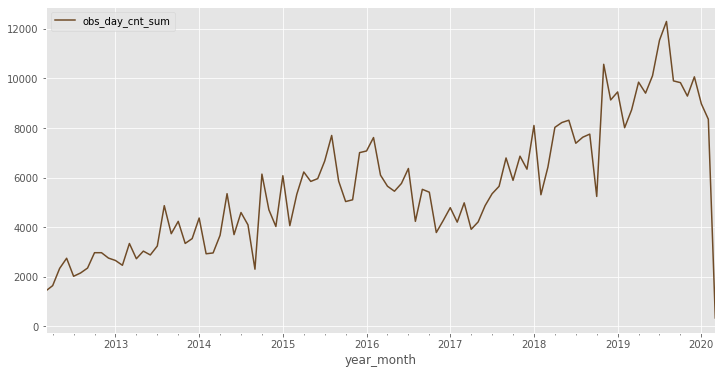

In [403]:
region = 'Permian Region'
df_month_agg[
    df_month_agg['region'] == region
].set_index('year_month')[['obs_day_cnt_sum']].plot(
    figsize=(12, 6),
    c=basin_colors_hex[region],
);  # expected dropoff, march is not complete for sum

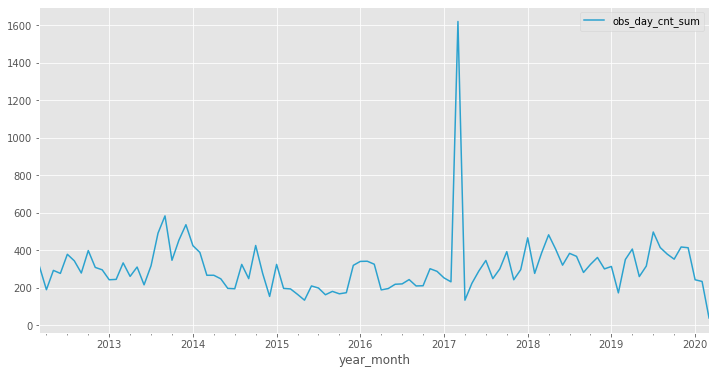

In [404]:
region = 'Anadarko Region'
df_month_agg[
    df_month_agg['region'] == region
].set_index('year_month')[['obs_day_cnt_sum']].plot(
    figsize=(12, 6),
    c=basin_colors_hex[region],
);  # expected dropoff, march is not complete for sum

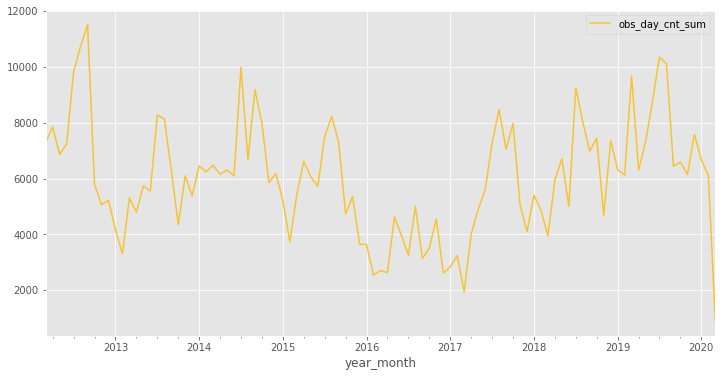

In [405]:
region = 'Bakken Region'
df_month_agg[
    df_month_agg['region'] == region
].set_index('year_month')[['obs_day_cnt_sum']].plot(
    figsize=(12, 6),
    c=basin_colors_hex[region],
);  # expected dropoff, march is not complete for sum

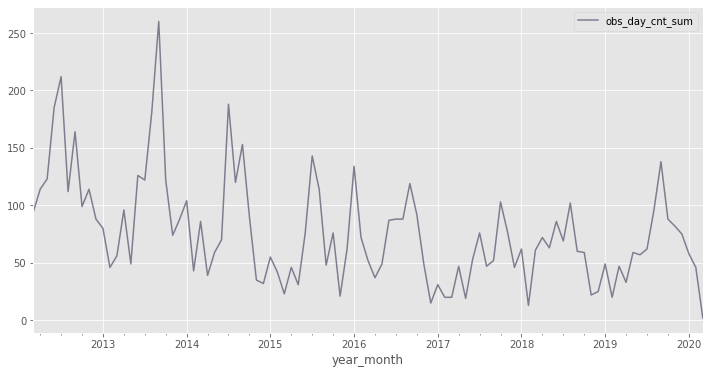

In [406]:
region = 'Haynesville Region'
df_month_agg[
    df_month_agg['region'] == region
].set_index('year_month')[['obs_day_cnt_sum']].plot(
    figsize=(12, 6),
    c=basin_colors_hex[region],
);  # expected dropoff, march is not complete for sum

In [407]:
df_month_agg.shape

(679, 32)

In [408]:
df_month_agg.shape[0] / 7. 
# number of months of data for each of the seven regions. 

97.0

In [409]:
all_basins[['region', 'geoid', 'aland']].head(6)
# next, create variable of total land area in square meters for basin
# geoid's are unique counties and aland is their land area

,region,geoid,aland
0,Permian Region,48327,2336237920
1,Permian Region,48189,2602109431
2,Appalachia Region,42007,1125901161
3,Appalachia Region,54075,2435322222
4,Haynesville Region,22111,2271359845
5,Appalachia Region,36101,3601504767


In [410]:
basin_area = all_basins[['region', 'aland']].groupby(
    ['region'],
    as_index=False,
).sum()

basin_area

,region,aland
0,Anadarko Region,75463801085
1,Appalachia Region,192181893591
2,Bakken Region,91261078507
3,Eagle Ford Region,64571223163
4,Haynesville Region,48802443064
5,Niobrara Region,232124086468
6,Permian Region,211875565064


In [411]:
df_month_agg = df_month_agg.merge(basin_area, on='region', how='left')

In [412]:
df_month_agg[['year_month', 'region', 'obs_day_cnt_sum', 'aland']]
# looks good. 

,year_month,region,obs_day_cnt_sum,aland
0,2012-03-01,Anadarko Region,313,75463801085
1,2012-03-01,Appalachia Region,870,192181893591
2,2012-03-01,Bakken Region,7289,91261078507
3,2012-03-01,Eagle Ford Region,1262,64571223163
4,2012-03-01,Haynesville Region,94,48802443064
...,...,...,...,...
674,2020-03-01,Bakken Region,900,91261078507
675,2020-03-01,Eagle Ford Region,59,64571223163
676,2020-03-01,Haynesville Region,2,48802443064
677,2020-03-01,Niobrara Region,32,232124086468


In [413]:
for i in df_month_agg.columns:
    if (i != 'year_month') & (i != 'region') & (i != 'aland'):
        df_month_agg[f'{i}_per_squaremeters'] = df_month_agg[i] / df_month_agg['aland']

In [417]:
df_month_agg.columns

Index(['year_month', 'region', 'obs_day_cnt_avg', 'obs_day_cnt_med',
       'obs_day_cnt_sum', 'obs_day_cnt_min', 'obs_day_cnt_max',
       'qf_fit_day_avg_avg', 'qf_fit_day_avg_med', 'qf_fit_day_avg_sum',
       'qf_fit_day_avg_min', 'qf_fit_day_avg_max', 'qf_fit_day_med_avg',
       'qf_fit_day_med_med', 'qf_fit_day_med_sum', 'qf_fit_day_med_min',
       'qf_fit_day_med_max', 'qf_fit_day_sum_avg', 'qf_fit_day_sum_med',
       'qf_fit_day_sum_sum', 'qf_fit_day_sum_min', 'qf_fit_day_sum_max',
       'qf_fit_day_min_avg', 'qf_fit_day_min_med', 'qf_fit_day_min_sum',
       'qf_fit_day_min_min', 'qf_fit_day_min_max', 'qf_fit_day_max_avg',
       'qf_fit_day_max_med', 'qf_fit_day_max_sum', 'qf_fit_day_max_min',
       'qf_fit_day_max_max', 'aland', 'obs_day_cnt_avg_per_squaremeters',
       'obs_day_cnt_med_per_squaremeters', 'obs_day_cnt_sum_per_squaremeters',
       'obs_day_cnt_min_per_squaremeters', 'obs_day_cnt_max_per_squaremeters',
       'qf_fit_day_avg_avg_per_squaremeters',
     

In [423]:
df_modeling = pd.merge(
    df_month_agg,
    eia_data[['month', 'region', 'oil_bbl_d_total_production']],
    left_on=['year_month', 'region'],
    right_on=['month', 'region'],
)

In [424]:
df_modeling

,year_month,region,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,qf_fit_day_avg_sum,...,qf_fit_day_min_sum_per_squaremeters,qf_fit_day_min_min_per_squaremeters,qf_fit_day_min_max_per_squaremeters,qf_fit_day_max_avg_per_squaremeters,qf_fit_day_max_med_per_squaremeters,qf_fit_day_max_sum_per_squaremeters,qf_fit_day_max_min_per_squaremeters,qf_fit_day_max_max_per_squaremeters,month,oil_bbl_d_total_production
0,2012-03-01,Anadarko Region,13.041667,12.5,313,3,33,4.786164,4.291667,114.867926,...,0.000000e+00,0.0,0.000000e+00,4.185230e-10,4.505471e-10,1.004455e-08,0.000000e+00,7.023235e-10,2012-03-01,2.542036e+05
1,2012-03-01,Appalachia Region,31.071429,32.0,870,1,86,9.502222,8.966184,266.062205,...,0.000000e+00,0.0,0.000000e+00,1.925259e-10,1.769157e-10,5.390726e-09,0.000000e+00,2.757804e-10,2012-03-01,3.200000e+04
2,2012-03-01,Bakken Region,260.321429,249.0,7289,2,571,1.497039,1.500962,41.917086,...,0.000000e+00,0.0,0.000000e+00,2.919411e-10,3.725575e-10,8.174350e-09,0.000000e+00,5.807514e-10,2012-03-01,5.952038e+05
3,2012-03-01,Eagle Ford Region,48.538462,30.0,1262,1,209,1.046799,0.374157,27.216779,...,0.000000e+00,0.0,0.000000e+00,2.060932e-10,1.548677e-11,5.358424e-09,0.000000e+00,8.207991e-10,2012-03-01,5.067076e+05
4,2012-03-01,Haynesville Region,4.476190,2.0,94,1,15,8.188339,0.000000,171.955128,...,1.413864e-09,0.0,6.966864e-10,3.180949e-10,0.000000e+00,6.679993e-09,0.000000e+00,1.086011e-09,2012-03-01,5.269823e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,2020-03-01,Bakken Region,300.000000,292.0,900,237,371,9.713328,9.410959,29.139984,...,0.000000e+00,0.0,0.000000e+00,4.017777e-10,3.725575e-10,1.205333e-09,3.725575e-10,4.602181e-10,2020-03-01,1.471809e+06
675,2020-03-01,Eagle Ford Region,19.666667,8.0,59,3,48,1.965278,0.729167,5.895833,...,0.000000e+00,0.0,0.000000e+00,1.858413e-10,1.548677e-11,5.575239e-10,1.548677e-11,5.265503e-10,2020-03-01,1.369389e+06
676,2020-03-01,Haynesville Region,1.000000,1.0,2,1,1,0.000000,0.000000,0.000000,...,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2020-03-01,3.916184e+04
677,2020-03-01,Niobrara Region,10.666667,13.0,32,4,15,6.447009,8.307692,19.341026,...,0.000000e+00,0.0,0.000000e+00,1.464734e-10,1.464734e-10,4.394201e-10,1.464734e-10,1.464734e-10,2020-03-01,7.687489e+05


In [425]:
df_modeling.to_csv(f"{wd}/processing/basin_int_viirs_for_modeling.csv", index=False)

In [ ]:
qf_detect_day_avg=pd.NamedAgg(column='qf_detect', aggfunc='mean'),
qf_detect_day_med=pd.NamedAgg(column='qf_detect', aggfunc='median'),
qf_detect_day_sum=pd.NamedAgg(column='qf_detect', aggfunc='sum'),
qf_detect_day_min=pd.NamedAgg(column='qf_detect', aggfunc='min'),
qf_detect_day_max=pd.NamedAgg(column='qf_detect', aggfunc='max'),
qf_fit_day_avg=pd.NamedAgg(column='qf_fit', aggfunc='mean'),
qf_fit_day_med=pd.NamedAgg(column='qf_fit', aggfunc='median'),
qf_fit_day_sum=pd.NamedAgg(column='qf_fit', aggfunc='sum'),
qf_fit_day_min=pd.NamedAgg(column='qf_fit', aggfunc='min'),
qf_fit_day_max=pd.NamedAgg(column='qf_fit', aggfunc='max'),

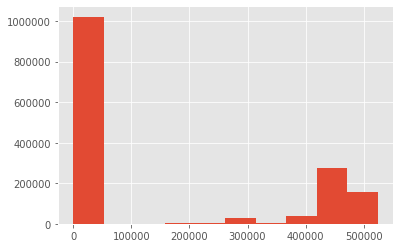

In [86]:
df['qf_detect'].hist();

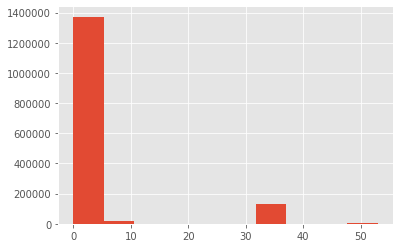

In [87]:
df['qf_fit'].hist();

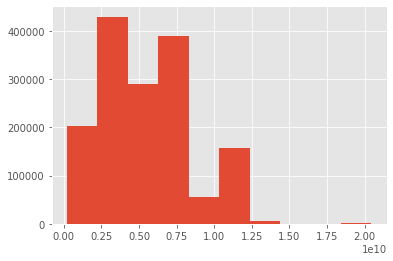

In [88]:
df['aland'].hist();

In [142]:
# df['county_land_sqmeters'] = df.groupby('geoid')['aland'].transform('mean')  
# get average of land, its based on geoid value from census data. 


In [129]:
# create sum of aland, groupby geoid, then drop geoid

0         946.0
1         948.0
2         946.0
3         948.0
4         948.0
          ...  
523070    697.0
523071    739.0
523072    744.0
523073    607.0
523074    235.0
Name: line_dnb, Length: 1532076, dtype: float64